# Setting

필요한 라이브러리를 불러옵니다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

코랩을 사용할 때에는 언제나 drive.mount를 해주어야 합니다.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Linear Regression

## 데이터 불러오기

사용할 데이터 셋: electricity.csv

전력 사용량 예측 모델을 선형회귀로 만들어봅시다.

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/DSL/23-2/[0718][HW]Regression_SVM/electricity.csv', encoding='cp949' )
data

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0
122396,60,2020-08-24 20,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0
122397,60,2020-08-24 21,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0
122398,60,2020-08-24 22,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0


건물 정보와 기후 정보를 활용한 전력사용량 예측 데이터 중에서

환경 변수(X: 기온, 풍속, 습도, 강수량, 일조)에 대해 전력 사용량(y)을 선형회귀 모델을 사용해서 예측해보고자 합니다.

100개의 data만 가져와서 실습을 진행하고자 합니다.
이때 train data : 88개, test data: 12개로 진행합니다.

In [5]:
var_name = ['Temp', 'Wind', 'Moisture', 'Precipitation', 'Sun']
target = 'Wh'

In [6]:
def parsing(data: pd.DataFrame):
    x = data.iloc[:, 3:8]
    x.columns = var_name
    y = data.iloc[:, 2]
    y.name = target

    return x, y

In [10]:
def load_data():
    data = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/DSL/23-2/[0718][HW]Regression_SVM/electricity.csv', encoding='cp949' )
    data = data[: 100] # 100개만 잘라서
    x, y = parsing(data)
    cut = int(round(len(x)*0.88)) #88개:train 나머지:test
    tr_x = x[:cut]
    tr_y = y[:cut]
    te_x = x[cut:]
    te_y = y[cut:]
    return tr_x, tr_y, te_x, te_y

In [11]:
train_x, train_y, test_x, test_y = load_data() #재정의

## 데이터 확인

주의! 최종 예측하는 단계 이전에는 현재 가지고 있는 데이터, 즉 train data만을 이용하여 작업을 진행해야 합니다.

현재 가지고 있는 데이터 train_x를 보고 전력 사용량을 예측하는데에 사용할 변수를 선택해주세요.

최적의 변수 조합을 찾아보도록 합시다.

①상관계수 확인
②다중공선성 확인

이 때 선택해야하는 변수는 하나일 수도 있고, 여러개의 변수가 될 수도 있습니다.

In [12]:
train_x

,Temp,Wind,Moisture,Precipitation,Sun
0,17.6,2.5,92.0,0.8,0.0
1,17.7,2.9,91.0,0.3,0.0
2,17.5,3.2,91.0,0.0,0.0
3,17.1,3.2,91.0,0.0,0.0
4,17.0,3.3,92.0,0.0,0.0
...,...,...,...,...,...
83,23.9,2.8,68.0,0.0,0.6
84,25.0,3.1,63.0,0.0,0.8
85,26.0,3.1,60.0,0.0,1.0
86,26.4,3.8,60.0,0.0,1.0


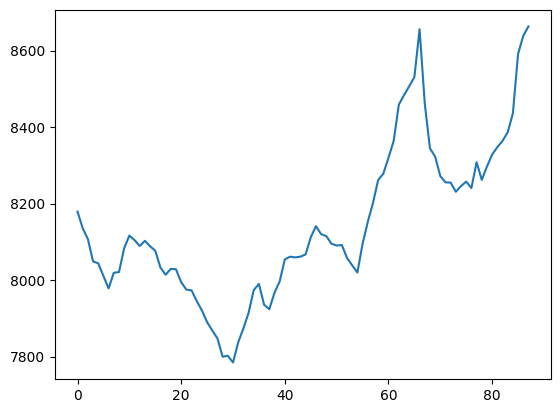

In [13]:
plt.plot(train_y)

In [14]:
#상관계수 확인
corr = pd.DataFrame(np.concatenate((train_x, train_y[:, np.newaxis]), axis=1), columns=var_name+[target]).corr()
corr

<ipython-input-14-dc4a71e58e9f>:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  corr = pd.DataFrame(np.concatenate((train_x, train_y[:, np.newaxis]), axis=1), columns=var_name+[target]).corr()


,Temp,Wind,Moisture,Precipitation,Sun,Wh
Temp,1.000000,0.510935,-0.628642,-0.173210,0.783829,0.803301
Wind,0.510935,1.000000,-0.478825,0.028617,0.544720,0.349288
Moisture,-0.628642,-0.478825,1.000000,0.152529,-0.699047,-0.095042
Precipitation,-0.173210,0.028617,0.152529,1.000000,-0.123846,-0.090389
Sun,0.783829,0.544720,-0.699047,-0.123846,1.000000,0.458348
Wh,0.803301,0.349288,-0.095042,-0.090389,0.458348,1.000000


In [15]:
# 상관계수를 보았을 때 일정 수준 이상 상관성이 있다고 판단되는 변수를 선택한다.
variables = ['Temp', 'Wind', 'Sun']
train_x = train_x[variables]
train_x

,Temp,Wind,Sun
0,17.6,2.5,0.0
1,17.7,2.9,0.0
2,17.5,3.2,0.0
3,17.1,3.2,0.0
4,17.0,3.3,0.0
...,...,...,...
83,23.9,2.8,0.6
84,25.0,3.1,0.8
85,26.0,3.1,1.0
86,26.4,3.8,1.0


In [16]:
# 전체 독립변수(train_x)에 대한 VIF값 구하기

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['features'] = train_x.columns
vif["VIF Factor"] = [variance_inflation_factor(train_x.values, i) for i in range(train_x.shape[1])]
vif

,features,VIF Factor
0,Temp,9.278102
1,Wind,10.057008
2,Sun,1.971685


In [17]:
#다중공선성이 10이 넘는 변수는 drop.
train_x =  train_x.drop('Wind',axis=1)

In [18]:
variables = train_x.columns
variables

Index(['Temp', 'Sun'], dtype='object')

In [19]:
# 다중공선성 재확인
vif = pd.DataFrame()
vif['features'] = train_x.columns
vif["VIF Factor"] = [variance_inflation_factor(train_x.values, i) for i in range(train_x.shape[1])]
vif

,features,VIF Factor
0,Temp,1.816925
1,Sun,1.816925


## 전처리 - 스케일링

위에서 선택한 변수들(feature)를 가지고 한번 전력 사용량을 예측하는 모델을 만들어 보기에 앞서,

**train 데이터의 feature의 전처리**를 진행해 봅시다.

In [20]:
# 사용할 패키지를 import!
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

In [21]:
scaler = MinMaxScaler().fit(train_x)
train_x = scaler.transform(train_x)

## 모델링

### 학습

linear regression model

In [23]:
#sklearn 패키지 linear_model 모듈에서 LinearRegression 가져오기
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression().fit(train_x, train_y) #Linear Regression model 생성

In [24]:
#회귀계수와 절편을 확인해보자!
print(linear_model.coef_) #회귀계수
print(linear_model.intercept_) #절편

[ 956.80285148 -217.78538838]
7816.8814336615615


In [25]:
#train_X 데이터 15개 예측
linear_model.predict(train_x)[:15]

array([8016.8103877 , 8023.95070749, 8009.67006791, 7981.10878877,
       7973.96846898, 7966.82814919, 7952.54750962, 7945.04961035,
       7965.75541076, 7985.74605221, 8006.09427315, 8120.33938974,
       8191.74258761, 8191.74258761, 8227.44418655])

###성능평가

In [26]:
#사이킷런 패키지 metrics 모듈에서 r2_score, mean_squared_error 함수 가져오기
from sklearn.metrics import r2_score, mean_squared_error # R^2, MSE

In [27]:
r2_score(train_y, linear_model.predict(train_x)) #r2_score(실제값, 예측값)

0.721391315413279

In [28]:
mean_squared_error(train_y, linear_model.predict(train_x)) #mean_squared_error(실제값, 예측값)

11423.540883265874

# Ridge & Lasso

Ridge와 Lasso의 경우 의미 없는 변수를 알아서 0으로 (또는 0에 가깝게) 만들어 준다! <br> 회귀계수에 관한 규제항을 추가한, 다중공선성에 강한 회귀 모델이다.
따라서 다중공선성/상관계수로 변수 제거를 시작하지 않고 진행해도 된다.

## 데이터 불러오기 및 전처리
Boston데이터를 새로 불러와서 Boston 집값을 Ridge와 Lasso로 예측해보자.

In [30]:
boston = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/DSL/23-2/[0718][HW]Regression_SVM/Boston_house.csv")
boston.head()

,AGE,B,RM,CRIM,DIS,INDUS,LSTAT,NOX,PTRATIO,RAD,ZN,TAX,CHAS,Target
0,65.2,396.90,6.575,0.00632,4.0900,2.31,4.98,0.538,15.3,1,18.0,296,0,24.0
1,78.9,396.90,6.421,0.02731,4.9671,7.07,9.14,0.469,17.8,2,0.0,242,0,21.6
2,61.1,392.83,7.185,0.02729,4.9671,7.07,4.03,0.469,17.8,2,0.0,242,0,34.7
3,45.8,394.63,6.998,0.03237,6.0622,2.18,2.94,0.458,18.7,3,0.0,222,0,33.4
4,54.2,396.90,7.147,0.06905,6.0622,2.18,5.33,0.458,18.7,3,0.0,222,0,36.2


x, y 데이터 분할

In [31]:
raw_x = boston.drop(['Target'], axis=1)
raw_y = boston['Target']

In [32]:
raw_x.columns

Index(['AGE', 'B', 'RM', 'CRIM', 'DIS', 'INDUS', 'LSTAT', 'NOX', 'PTRATIO',
       'RAD', 'ZN', 'TAX', 'CHAS'],
      dtype='object')

## 훈련/테스트 세트 분리


훈련 세트와 테스트 세트로 데이터 분리
데이터셋을 훈련세트와 테스트 세트로 나누는 것은 사이킷런 패키지의 train_test_split 함수로 쉽게 구현할 수 있다.

sklearn.model_selection.train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)

훈련 세트: 모델 학습 / 훈련시키기 위한 데이터셋 <br>
테스트 세트: 모델의 성능을 평가하기 위한 데이터셋으로, **절대** 모델 훈련 과정에 관여해서는 안 된다.

In [33]:
#sklearn 패키지의 model_selection 모듈에서 train_test_split 함수를 갖고 오겠다
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(raw_x, raw_y,
                                                    train_size=0.7, #훈련 세트 사이즈: 0.7
                                                    test_size=0.3, #테스트 세트 사이즈: 0.3
                                                    random_state=1) #랜덤 시드 설정

In [34]:
#shape 확인
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(354, 13) (152, 13) (354,) (152,)


## 스케일링

독립변수들 간 스케일을 맞춰주는 작업 > 회귀계수 해석에 도움 <br>
종속변수인 Y에 대해서는 스케일링 할 필요 없음 <br>
여기서는 StandardScaler를 사용하겠다!

In [35]:
#sklearn 패키지 preprocessing 모듈에서 StandardScaler 가져오기
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() #빈 스케일러 생성
scaler = scaler.fit(train_x) #이후 이 스케일러를 train_X에 맞는 스케일러로 만들어준다.
#주의) fit할 때는 무조건 train_X로 스케일러를 만들어줘야한다. 테스트 세트는 모델 구현에 일절 관여해선 안 됨!

train_x_scaled = scaler.transform(train_x) #train_X 데이터 변환
test_x_scaled = scaler.transform(test_x) #test_X 데이터 변환
print(test_x_scaled[:5])

[[ 0.04993471  0.43987709  0.86104176 -0.43390418 -0.3021049  -1.33216561
  -0.74735561 -0.70670089 -0.02384719 -0.30467281  0.92062021 -1.10027405
  -0.30429031]
 [-0.44246754  0.43987709  0.63984211 -0.43671065  0.89239452 -1.09858981
  -0.79551142 -0.60488281 -0.39697005 -0.53221326  1.85680748 -0.22954784
  -0.30429031]
 [ 0.58838896  0.39379457 -0.32302696 -0.41276468  0.87238781 -0.64165714
   0.80326144 -0.91033705 -0.25704898 -0.75975371 -0.48366069 -1.03555792
  -0.30429031]
 [-1.68232931  0.43223359 -0.54278087 -0.43289743  1.25125038 -0.76428444
  -0.66893044 -1.24124581  0.2093546  -0.64598348  0.04826389 -0.37662997
  -0.30429031]
 [ 0.96743242  0.2614181  -1.28878753 -0.00760165 -0.80770792  0.99191363
  -0.38137146  1.82178145  0.81567925  1.62942102 -0.48366069  1.51190459
  -0.30429031]]


## 모델링

In [36]:
#sklearn 패키지 linear_model 모듈에서 Ridge, Lasso 가져오기
from sklearn.linear_model import Ridge, Lasso

#모델 생성
r_model = Ridge(alpha=1.0).fit(train_x_scaled, train_y) #Ridge 모델 생성
l_model = Lasso(alpha=1.0).fit(train_x_scaled, train_y) #Lasso 모델 생성


Ridge

In [37]:
# Ridge: 규제항이 회귀계수의 제곱합이므로 회귀계수들이 딱 0이 되지는 않고, 0에 가까워진다.
print(r_model.coef_)
print(r_model.intercept_)

[ 0.08786471  0.58420966  1.95068061 -0.82422532 -3.18468949  0.36575078
 -4.11001931 -2.48298904 -2.14571176  2.58633866  1.392506   -1.80548175
  0.685604  ]
22.33983050847458


Lasso

In [38]:
# Lasso: 규제항이 회귀계수의 절댓값 합이므로 회귀계수들이 0에 수렴한다.
print(l_model.coef_)
print(l_model.intercept_)

[-0.00000000e+00  0.00000000e+00  1.95271813e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -3.95564352e+00 -0.00000000e+00
 -1.35341659e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  2.77756477e-03]
22.339830508474577


## 성능평가

In [39]:
from sklearn.metrics import r2_score, mean_squared_error # R^2, MSE

생성한 각각의 모델에 대해 MSE값을 확인해보고 적절한 모델을 선택합니다.

In [40]:
# MSE; mean_squared_error
print("MSE for Ridge model : {:.2f}".format(mean_squared_error(test_y, r_model.predict(test_x_scaled))))
print("MSE for Lasso model : {:.2f}".format(mean_squared_error(test_y, l_model.predict(test_x_scaled))))

MSE for Ridge model : 19.81
MSE for Lasso model : 29.89


#Logistic Regression

sklearn의 유방암 데이터로 로지스틱 회귀분석을 진행해봅시다.

## 데이터 불러오기

In [41]:
# 실습용 데이터 패키지
from sklearn.datasets import load_iris, make_moons, load_breast_cancer

# 데이터셋 로드 및 설명
breast_cancer = load_breast_cancer()
print(breast_cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [42]:
# X 변수 및 Y 변수 확인
print(breast_cancer.feature_names)
print(breast_cancer.target_names) ## class {"0":'malignant',"1":"benign"}

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
['malignant' 'benign']


## 전처리

In [43]:
# Train set/ Test set 나누기
X_train, X_test, y_train, y_test = train_test_split(breast_cancer.data,
                                                   breast_cancer.target,
                                                   test_size=0.3,
                                                   random_state=2021)
# 데이터 컬럼 단위 정규화 하기
from sklearn.preprocessing import StandardScaler

normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

## 모델링

logreg.score: 이 메서드는 학습된 모델에 입력 데이터를 제공하고, 모델이 예측한 결과와 실제 결과를 비교하여 정확도를 계산합니다. 정확도는 예측이 올바르게 이루어진 데이터의 비율로 나타납니다.

In [45]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=0.01).fit(X_train, y_train)
print("train set score : ", logreg.score(X_train, y_train))  # 0.954
print("test set score : ", logreg.score(X_test, y_test))   # 0.941

train set score :  0.9547738693467337
test set score :  0.9415204678362573


In [46]:
pred_10 = logreg.predict(X_test)

print('실제 값: ',y_test[:30])	# 실제 값:  [1 0 1 1 0 0 0 0 0 1]
print('예측 값: ',pred_10[:30])	# 예측 값:  [1 0 1 1 1 0 1 0 0 1]


실제 값:  [1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1]
예측 값:  [1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1]


#SVM

In [47]:
# 실습용 데이터 패키지
from sklearn.datasets import load_iris, make_moons

# 전처리
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# 기계학습 모델 및 평가
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

# 시각화
import seaborn as sns

## 선형 SVM

iris dataset: binary classification

In [48]:
iris = load_iris()
iris_data = pd.DataFrame(data=np.c_[iris['data'], iris['target']], columns=iris['feature_names']+['target'])
iris_data['target'] = iris_data['target'].map({0:'setosa', 1:'versicolor', 2:'virginica'})
iris_data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [49]:
# iris데이터의 2개 class(Iris-setosa, Iris-Versicolor)에 대해 고려해보자

X = iris['data'][:,(2,3)]

scaler = StandardScaler()
Xstan = scaler.fit_transform(X)

df = pd.DataFrame(data=Xstan, columns=['petal length','petal width'])
df['target'] = iris['target']
df = df[df['target']!=2] # Iris-setosa 와 Iris-Versicolor 에 대해 고려해보자
df.head()

,petal length,petal width,target
0,-1.340227,-1.315444,0
1,-1.340227,-1.315444,0
2,-1.397064,-1.315444,0
3,-1.283389,-1.315444,0
4,-1.340227,-1.315444,0


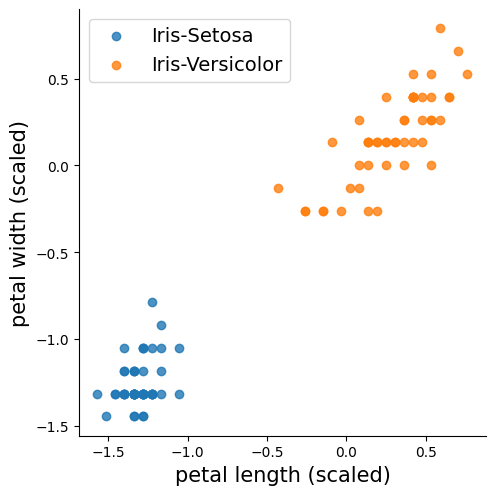

In [50]:
sns.lmplot(x='petal length',y='petal width',hue='target',data=df, fit_reg=False, legend=False)
plt.legend(['Iris-Setosa','Iris-Versicolor'], fontsize = 14)
plt.xlabel('petal length (scaled)', fontsize = 15)
plt.ylabel('petal width (scaled)', fontsize = 15)
plt.show()

### Hard Margin (Large C)

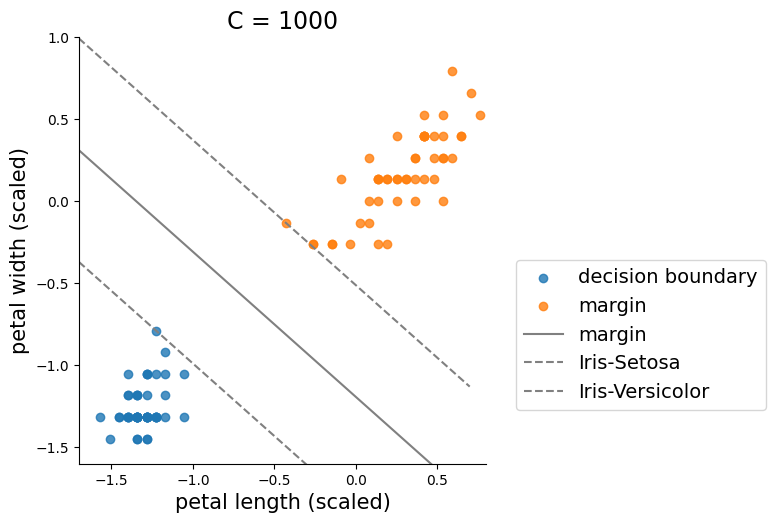

In [51]:
# Linear Hard

C= 1000
svc = LinearSVC(C=C,loss="hinge")
svc.fit(df[['petal length','petal width']].values,df['target'].values)

# 파라미터 (W, b) 도출하기
w0,w1 = svc.coef_[0]
b = svc.intercept_[0]

x0 = np.linspace(-1.7, 0.7, num=100)
# 결정 경계 (decision boundary) 도출하기
x1_decision = -b/w1 - w0/w1*x0

# +1 margin
x1_plus = x1_decision + 1/w1
# -1 margin
x1_minus = x1_decision - 1/w1

sns.lmplot(x='petal length',y='petal width',hue='target',data=df, fit_reg=False, legend=False)
plt.plot(x0,x1_decision, color='grey')
plt.plot(x0,x1_plus,x0,x1_minus,color='grey', linestyle='--')
plt.legend(['decision boundary','margin','margin','Iris-Setosa','Iris-Versicolor'], fontsize = 14, bbox_to_anchor=(1.05,0.5))
plt.xlabel('petal length (scaled)', fontsize = 15)
plt.ylabel('petal width (scaled)', fontsize = 15)
plt.title(f'C = {C}', fontsize = 17)
plt.ylim(-1.6,1)
plt.xlim(-1.7,0.8)
plt.show()

### Soft Margin (Small C)

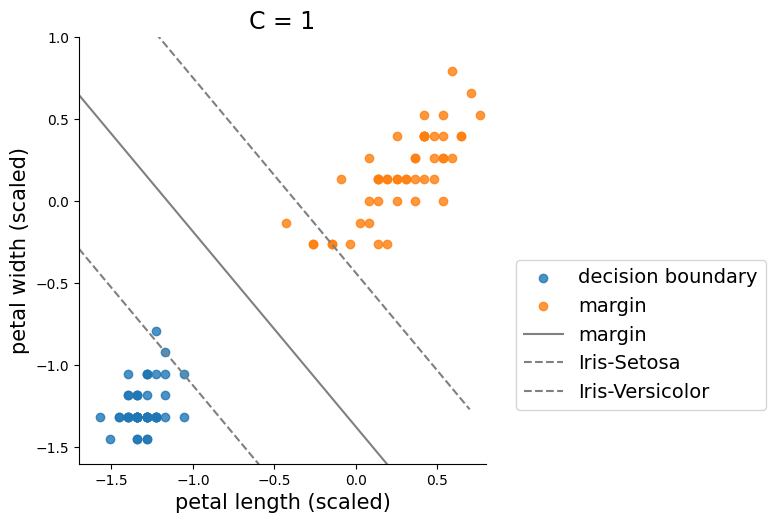

In [52]:
# Linear Soft

C= 1
svc = LinearSVC(C=C,loss="hinge")
svc.fit(df[['petal length','petal width']].values,df['target'].values)

# 파라미터 (W, b) 도출하기
w0,w1 = svc.coef_[0]
b = svc.intercept_[0]

x0 = np.linspace(-1.7, 0.7, num=100)
# 결정 경계 (decision boundary) 도출하기
x1_decision = -b/w1 - w0/w1*x0

# +1 margin
x1_plus = x1_decision + 1/w1
# -1 margin
x1_minus = x1_decision - 1/w1

sns.lmplot(x='petal length',y='petal width',hue='target',data=df, fit_reg=False, legend=False)
plt.plot(x0,x1_decision, color='grey')
plt.plot(x0,x1_plus,x0,x1_minus,color='grey', linestyle='--')
plt.legend(['decision boundary','margin','margin','Iris-Setosa','Iris-Versicolor'], fontsize = 14, bbox_to_anchor=(1.05,0.5))
plt.xlabel('petal length (scaled)', fontsize = 15)
plt.ylabel('petal width (scaled)', fontsize = 15)
plt.title(f'C = {C}', fontsize = 17)
plt.ylim(-1.6,1)
plt.xlim(-1.7,0.8)
plt.show()

## 비선형 SVM

moons dataset: nonseparable cases

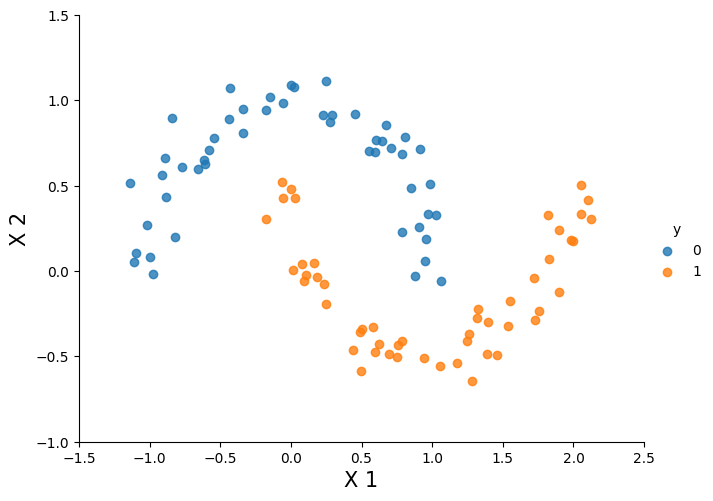

In [53]:
X,y=make_moons(noise=0.1, random_state=2) # fix random_state to make sure it produces the same dataset everytime. Remove it if you want randomized dataset.
df = pd.DataFrame(data = X, columns=['x1','x2'])
df['y']=y
df.head()

sns.lmplot(x='x1',y='x2',hue='y',data=df, fit_reg=False, legend=True, aspect=4/3)
plt.xlim(-1.5,2.5)
plt.ylim(-1,1.5)
plt.xlabel('X 1', fontsize = 15)
plt.ylabel('X 2', fontsize = 15)
plt.show()

### Polynomial Kernel : degree 3

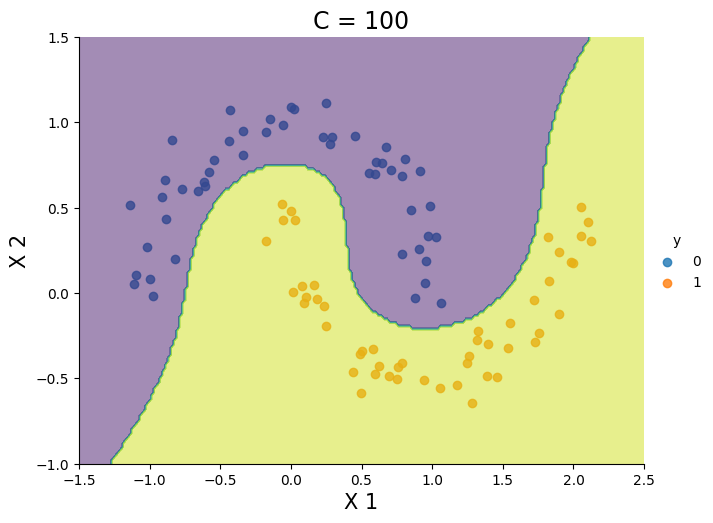

In [55]:
C=100
scaler = StandardScaler()
Xstan = scaler.fit_transform(X)
svm_clf =SVC(kernel='poly', degree=3, C=C, coef0=1)
svm_clf.fit(Xstan,y)

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

# create grids
X0, X1 = X[:, 0], X[:, 1]
xx0, xx1 = make_meshgrid(X0, X1)
# standardization on the grids
xgrid = np.c_[xx0.ravel(), xx1.ravel()]
xgridstan = scaler.transform(xgrid)

# prediction
Z = svm_clf.predict(xgridstan)
Z = Z.reshape(xx0.shape)

# plotting prediction contours - decision boundary (Z=0), and two margins (Z = 1 or -1)
sns.lmplot(x='x1',y='x2',hue='y',data=df, fit_reg=False, legend=True, aspect=4/3)
plt.contourf(xx0, xx1, Z, alpha=0.5)
plt.xlim(-1.5,2.5)
plt.ylim(-1,1.5)
plt.xlabel('X 1', fontsize = 15)
plt.ylabel('X 2', fontsize = 15)
plt.title(f'C = {C}', fontsize = 17)
plt.show()